# DATA 512 Final Project – Part 1
## Initial Data Exploration and Distance Computation

In [53]:
import os
import json
from pyproj import Transformer, Geod
from tqdm import tqdm

PROJECT_DIR = "/Users/daniel_personal/Documents/uw/msds_courses/data512/final_project"

os.chdir(PROJECT_DIR)

from wildfire.Reader import Reader

DATA_NAME = "raw_data/USGS_Wildland_Fire_Combined_Dataset.json"

DATA_FILEPATH = os.path.join(PROJECT_DIR, DATA_NAME)

wfreader = Reader(DATA_FILEPATH)

header_dict = wfreader.header()
print(json.dumps(header_dict,indent=4))

{
    "displayFieldName": "",
    "fieldAliases": {
        "OBJECTID": "OBJECTID",
        "USGS_Assigned_ID": "USGS Assigned ID",
        "Assigned_Fire_Type": "Assigned Fire Type",
        "Fire_Year": "Fire Year",
        "Fire_Polygon_Tier": "Fire Polygon Tier",
        "Fire_Attribute_Tiers": "Fire Attribute Tiers",
        "GIS_Acres": "GIS_Acres",
        "GIS_Hectares": "GIS_Hectares",
        "Source_Datasets": "Source Datasets",
        "Listed_Fire_Types": "Listed Fire Types",
        "Listed_Fire_Names": "Listed Fire Names",
        "Listed_Fire_Codes": "Listed Fire Codes",
        "Listed_Fire_IDs": "Listed Fire IDs",
        "Listed_Fire_IRWIN_IDs": "Listed Fire IRWIN IDs",
        "Listed_Fire_Dates": "Listed Fire Dates",
        "Listed_Fire_Causes": "Listed Fire Causes",
        "Listed_Fire_Cause_Class": "Listed Fire Cause Class",
        "Listed_Rx_Reported_Acres": "Listed Rx Reported Acres",
        "Listed_Map_Digitize_Methods": "Listed Map Digitize Methods",
    

In [54]:
#
#    This sample code will load the whole sample (extracted data) file, or a small amount of the complete dataset.
#
MAX_FEATURE_LOAD = 1e20
feature_list = list()
feature_count = 0
# A rewind() on the reader object makes sure we're at the start of the feature list
# This way, we can execute this cell multiple times and get the same result 
wfreader.rewind()
# Now, read through each of the features, saving them as dictionaries into a list
feature = wfreader.next()
while feature:
    feature_list.append(feature)
    feature_count += 1
    # if we're loading a lot of features, print progress
    if (feature_count % 10000) == 0:
        print(f"Loaded {feature_count} features")
    # loaded the max we're allowed then break
    if feature_count >= MAX_FEATURE_LOAD:
        break
    feature = wfreader.next()
#
#    Print the number of items (features) we think we loaded
print(f"Loaded a total of {feature_count} features")
#
#    Just a validation check - did all the items we loaded get into the list?
print(f"Variable 'feature_list' contains {len(feature_list)} features")




Loaded 10000 features
Loaded 20000 features
Loaded 30000 features
Loaded 40000 features
Loaded 50000 features
Loaded 60000 features
Loaded 70000 features
Loaded 80000 features
Loaded 90000 features
Loaded 100000 features
Loaded 110000 features
Loaded 120000 features
Loaded 130000 features
Loaded a total of 135061 features
Variable 'feature_list' contains 135061 features


In [98]:
geodcalc = Geod(ellps='WGS84')

#    Two constants for accessing the 'latlon' array in our CITY_LOCATIONS constant dict
LAT = 0
LON = 1


In [99]:
#
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        try:
            lat,lon = to_epsg4326.transform(coord[0],coord[1])
            new_coord = lat,lon
            converted_ring.append(new_coord)
        # sometimes, coords in this data are not correctly formatted; instead
        # of being [lat, lon] they are dicts like {'a': [[lat, lon], [lat, lon]]}...
        # if this is the case; I'm skipping it. Should not materially affect
        # the distance calculation in this use case
        except:
            converted_ring.append(None)
    return converted_ring

#    
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns a list containing the shortest distance to the perimeter and the point where that is
#
def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        if point is None:
            continue
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point



#    
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns the average miles from boundary to the place
#
def average_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    # create a list to store our results
    distances_in_meters = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        if point is None:
            continue
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        distances_in_meters.append(d[2])
    #print("Got the following list:",distances_in_meters)
    # convert meters to miles
    distances_in_miles = [meters*0.00062137 for meters in distances_in_meters]
    # the esri polygon shape (the ring) requires that the first and last coordinates be identical to 'close the region
    # we remove one of them so that we don't bias our average by having two of the same point
    distances_in_miles_no_dup = distances_in_miles[1:]
    # now, average miles
    try:
        average = sum(distances_in_miles_no_dup)/len(distances_in_miles_no_dup)
    except:
        average = float('inf')
    return average



In [96]:
place = {
    "city": "Pueblo, CO",
    "latlon": [38.2706, -104.6101]   
}

shortest_distances = []
average_distances = []

for wf_feature in tqdm(feature_list):
    #print(f"{place['city']}")
    wf_year = wf_feature['attributes']['Fire_Year']
    wf_name = wf_feature['attributes']['Listed_Fire_Names'].split(',')[0]
    wf_size = wf_feature['attributes']['GIS_Acres']
    wf_type = wf_feature['attributes']['Assigned_Fire_Type']
    if 'rings' in wf_feature['geometry']:
        ring_data = wf_feature['geometry']['rings'][0]
    elif 'curveRings' in wf_feature['geometry']:
        ring_data = wf_feature['geometry']['curveRings'][0]
    else:
        raise Exception("HEY! No compatible geometry in this fire data!!!")
    #
    #     Compute using the shortest distance to any point on the perimeter
    #
    distance = shortest_distance_from_place_to_fire_perimeter(place['latlon'],ring_data)
    shortest_distances.append(distance)
    # print(f"The closest distance of fire '{wf_name}' ({wf_size:1.2f} acres) from {wf_year} was {distance[0]:1.2f} miles to {place['city']}")
    # print(f"\tThe cloest perimiter point lat,lon {distance[1][0]},{distance[1][1]}")
    # #
    #     Compute using the average distance to all points on the perimeter
    #
    distance = average_distance_from_place_to_fire_perimeter(place['latlon'],ring_data)
    average_distances.append(distance)
    # just get a location to print thats on the ring (perimeter)
    # ring = convert_ring_to_epsg4326(ring_data)
    # perimeter_start = ring[0]
    # print(f"\tOne perimiter point lat,lon {perimeter_start[0]},{perimeter_start[1]}")
    # print()
    # print()

 80%|████████  | 108276/135061 [30:26<07:36, 58.68it/s]  

In [89]:
len(shortest_distances) == len(feature_list)

True

In [90]:
for i, feature in tqdm(enumerate(feature_list)):
    feature["attributes"]["DistanceToPueblo"] = shortest_distances[i]

135061it [00:00, 298345.39it/s]


In [91]:
shortest_distances_only = [x[0] for x in shortest_distances]

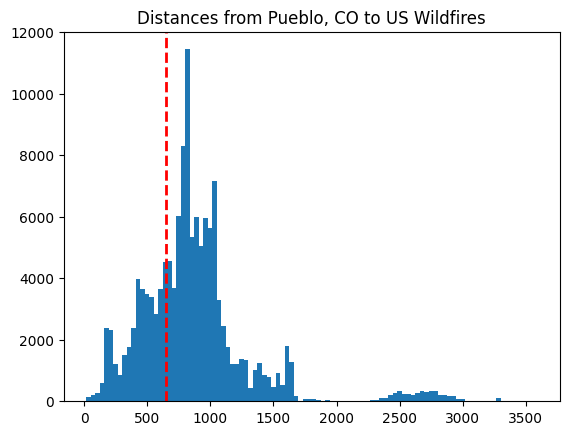

In [95]:
import matplotlib.pyplot as plt

plt.hist(shortest_distances_only, bins=100)
plt.title("Distances from Pueblo, CO to US Wildfires")
# TODO: ADD CUTOFFS PER INSTRUCTIONS
plt.axvline(x=650, color='red', linestyle='--', linewidth=2, label='Vertical Line')

plt.show()